<a href="https://colab.research.google.com/github/ab-sa/Statistical-Machine-Learning/blob/main/Leecture11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [4]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from scipy.interpolate import BSpline, splrep, splev

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
Steel = pd.read_csv('SteelStock_monthly.csv')
Steel.head()

,month,year,day,price,Date,Ind
0,1,1386,1,1879.501993,2007-03-21,1
1,1,1387,1,3413.524091,2008-03-20,2
2,1,1388,1,1814.074534,2009-03-21,3
3,1,1389,1,2591.221577,2010-03-21,4
4,1,1390,1,2356.125452,2011-03-21,5


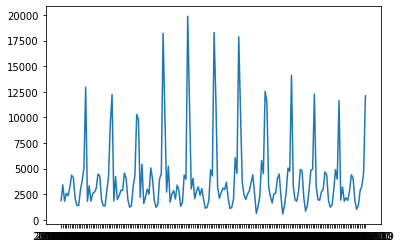

In [6]:
plt.plot(Steel['Date'], Steel['price'])
plt.show()

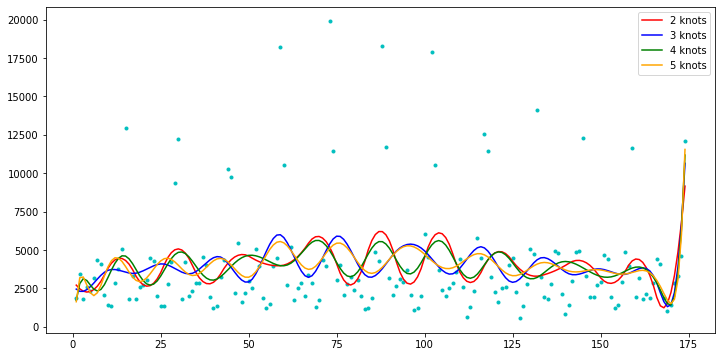

In [7]:
# Fit
n_interior_knots = 20
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(Steel['Ind'], qs)
tck_2 = splrep(Steel['Ind'], Steel['price'], t=knots, k=2)
ys_smooth_2 = BSpline(*tck_2)(Steel['Ind'])
tck_3 = splrep(Steel['Ind'], Steel['price'], t=knots, k=3)
ys_smooth_3 = BSpline(*tck_3)(Steel['Ind'])
tck_4 = splrep(Steel['Ind'], Steel['price'], t=knots, k=4)
ys_smooth_4 = BSpline(*tck_4)(Steel['Ind'])
tck_5 = splrep(Steel['Ind'], Steel['price'], t=knots, k=5)
ys_smooth_5 = BSpline(*tck_5)(Steel['Ind'])

# Display
plt.figure(figsize=(12, 6))
plt.plot(Steel['Ind'], Steel['price'], '.c')
plt.plot(Steel['Ind'], ys_smooth_2, '-m', color = 'red', label='2 knots')
plt.plot(Steel['Ind'], ys_smooth_3, '-m', color = 'blue', label='3 knots')
plt.plot(Steel['Ind'], ys_smooth_4, '-m', color = 'green', label='4 knots')
plt.plot(Steel['Ind'], ys_smooth_5, '-m', color = 'orange', label='5 knots')
plt.legend()
plt.show()

B-Spline r-MSPE:  3905.53178764495
Natural-Spline r-MSPE:  3869.1215093949986


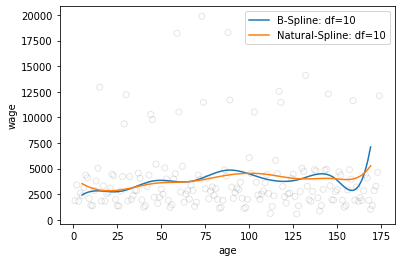

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(Steel['Ind'], Steel['price'], test_size=0.33, random_state=1)

from patsy import dmatrix 
import statsmodels.api as sm

# generating cubic spline with 3 knots at 25, 40 and 60
transformed_x_bs = dmatrix("bs(train, df=10, degree=3)", {"train": train_x}, return_type='dataframe')
transformed_x_ns = dmatrix("cr(train, df=10)", {"train": train_x}, return_type='dataframe')

# fitting generalized linear model on transformed dataset
fit_bs = sm.GLM(train_y, transformed_x_bs).fit()
fit_ns = sm.GLM(train_y, transformed_x_ns).fit()

# predictions on both splines
pred_bs = fit_bs.predict(dmatrix("bs(valid, df=10, degree=3)", {"valid":valid_x}, return_type='dataframe'))
pred_ns = fit_ns.predict(dmatrix("cr(valid, df=10)", {"valid":valid_x}, return_type='dataframe'))

# calculating rmse
rms_bs = np.sqrt(mean_squared_error(valid_y, pred_bs))
rms_ns = np.sqrt(mean_squared_error(valid_y, pred_ns))
print('B-Spline r-MSPE: ', rms_bs)
print('Natural-Spline r-MSPE: ', rms_ns)

# we wil plot the graph for 70 observations only
xp = np.linspace(valid_x.min(), valid_x.max(), 100)

# make some predictions
pred_bs = fit_bs.predict(dmatrix("bs(xp, df=10, degree=3)", {"xp":xp}, return_type='dataframe'))
pred_ns = fit_ns.predict(dmatrix("bs(xp, df=10, degree=3)", {"xp":xp}, return_type='dataframe'))

# plot the splines and error bands
plt.scatter(Steel.Ind, Steel.price, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred_bs, label='B-Spline: df=10')
plt.plot(xp, pred_ns, label='Natural-Spline: df=10')
plt.legend()
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

In [68]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

bs = BSplines(train_x, df=[12, 10], degree=[3, 3])


**Smoothing splines**: These models are not well supported in python. So, we will use R functions instead:

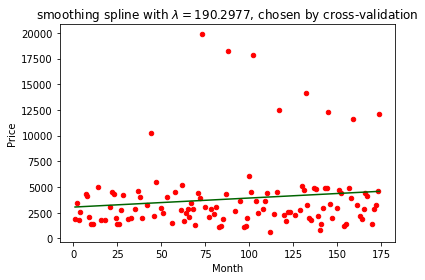

In [69]:
import rpy2.robjects as robjects

r_smooth_spline = robjects.r['smooth.spline'] #extract R function

pd_train_df = pd.DataFrame({"Month":train_x, "Price":train_y})

r_train_x = robjects.FloatVector(train_x)
r_train_y = robjects.FloatVector(train_y)
sSpline_cv = r_smooth_spline(r_train_x, r_train_y, cv=True)
lambda_cv = sSpline_cv.rx2("lambda")[0]

ax19 = pd_train_df.plot.scatter(x='Month',y='Price',c='Red',title="smoothing spline with $\lambda=$"+str(np.round(lambda_cv,4))+", chosen by cross-validation")
ax19.set_xlabel("Month")
ax19.set_ylabel("Price")
ax19.plot(sSpline_cv.rx2("x"),sSpline_cv.rx2("y"),color="darkgreen");

Useing the same function, but this time working with df tuning parameter:

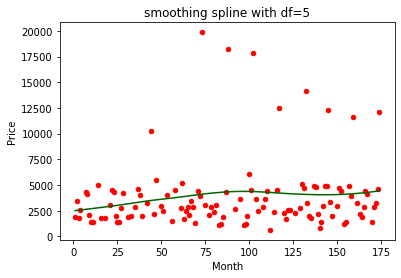

In [70]:
sSpline_df = r_smooth_spline(r_train_x, r_train_y, df=5)

ax19 = pd_train_df.plot.scatter(x='Month',y='Price',c='Red',title="smoothing spline with df=5")
ax19.set_xlabel("Month")
ax19.set_ylabel("Price")
ax19.plot(sSpline_df.rx2("x"),sSpline_df.rx2("y"),color="darkgreen");

**LOWESS Smoothing**: Repeat a a LOWESS model on the same dataset.

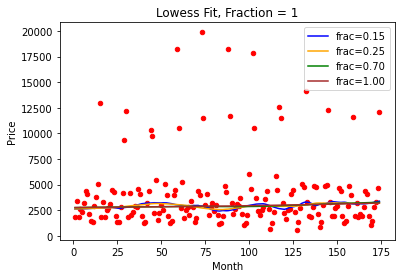

In [75]:
from statsmodels.nonparametric.smoothers_lowess import lowess as lowess

loess1 = lowess(train_y, train_x, frac=0.15)
loess2 = lowess(train_y, train_x, frac=0.25)
loess3 = lowess(train_y, train_x, frac=0.7)
loess4 = lowess(train_y, train_x, frac=1)

ax = Steel.plot.scatter(x='Ind',y='price',c='Red',title="Lowess Fit, Fraction = {}".format(cur_frac))
ax.set_xlabel("Month")
ax.set_ylabel("Price")
ax.plot(loess1[:,0],loess1[:,1],color="blue", label='frac=0.15')
ax.plot(loess2[:,0],loess2[:,1],color="orange", label='frac=0.25')
ax.plot(loess3[:,0],loess3[:,1],color="green", label='frac=0.70')
ax.plot(loess4[:,0],loess4[:,1],color="brown", label='frac=1.00')
plt.legend()
plt.show()

Using the same model, but this time working with df tuning parameter. Again, this would be a lot easier to use R functions instaed.

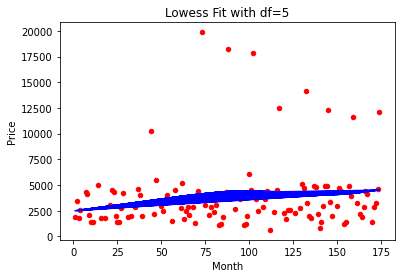

In [76]:
r_loess = robjects.r['loess'] #extract R function
r_loess_pred = robjects.r['predict'] #extract R function

from rpy2.robjects import pandas2ri
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter):
  r_train_df = robjects.conversion.py2rpy(pd_train_df)

loess_1 = r_loess(formula="Price~Month", data=r_train_df, enp_target=5)
loess_1_pred = r_loess_pred(loess_1)
ax = pd_train_df.plot.scatter(x='Month',y='Price',c='Red',title="Lowess Fit with df=5")
ax.set_xlabel("Month")
ax.set_ylabel("Price")
ax.plot(train_x, loess_1_pred, color="blue")
plt.show()